In [ ]:
import pandas as pd
data = pd.read_csv("/content/marketing_campaign.csv", sep="\t")
print("Number of datapoints:", len(data))
data.head()

Number of datapoints: 2240


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [ ]:
#Importing the Libraries
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)

#Feature Engineering

engineer some new features:

"Age" indicates the birth year of the respective person.

"Spent" indicates the total amount spent by the customer in various categories over the span of two years.

"Living_With" indicates the living situation of couples.

"Children" indicates total children in a household

"Family_Size" indicates total number of people living in the house

"Is_Parent" indicates parenthood status

simplyfy "Education" value counts. Dropping some of the redundant features

"Customer_For" indicates the number of days the customers started to shop in the store relative to the last recorded date

In [ ]:
#Feature Engineering
#Age of customer in 2021
data["Age"] = 2021-data["Year_Birth"]

#Total spendings
data["Spent"] = data["MntWines"]+ data["MntFruits"]+ data["MntMeatProducts"]+ data["MntFishProducts"]+ data["MntSweetProducts"]+ data["MntGoldProds"]

#Deriving living situation
data["Living_With"]=data["Marital_Status"].replace({"Married":"Partner", "Together":"Partner", "Absurd":"Alone", "Widow":"Alone", "YOLO":"Alone", "Divorced":"Alone", "Single":"Alone",})

#Total children in the house
data["Children"]=data["Kidhome"]+data["Teenhome"]

#Total family members
data["Family_Size"] = data["Living_With"].replace({"Alone": 1, "Partner":2})+ data["Children"]

#Rarenthood
data["Is_Parent"] = np.where(data.Children> 0, 1, 0)

#Simplify education levels
data["Education"]=data["Education"].replace({"Basic":"Undergraduate","2n Cycle":"Undergraduate", "Graduation":"Graduate", "Master":"Postgraduate", "PhD":"Postgraduate"})

#rename product categories
data=data.rename(columns={"MntWines": "Wines","MntFruits":"Fruits","MntMeatProducts":"Meat","MntFishProducts":"Fish","MntSweetProducts":"Sweets","MntGoldProds":"Gold"})

data["Dt_Customer"] = pd.to_datetime(data["Dt_Customer"])
dates = []
for i in data["Dt_Customer"]:
    i = i.date()
    dates.append(i)

#Created a feature "Customer_For"
days = []
d1 = max(dates) #taking it to be the newest customer
for i in dates:
    delta = d1 - i
    days.append(delta)
data["Customer_For"] = days
data["Customer_For"] = pd.to_numeric(data["Customer_For"], errors="coerce")

#remove replaced features
fea_drop = ["Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth", "ID"]
data = data.drop(fea_drop, axis=1)

<ipython-input-3-0985482180ce>:26: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  data["Dt_Customer"] = pd.to_datetime(data["Dt_Customer"])


#Data Cleaning

Removing missing value

In [ ]:
#To remove the missing values
data = data.dropna()
print("The total number of data-points after removing the rows with missing values are:", len(data))

The total number of data-points after removing the rows with missing values are: 2216


Handling Outliers

In [ ]:
data = data[(data["Age"]<90)]
data = data[(data["Income"]<113000)]
print("The total number of data-points after removing the outliers are:", len(data))

The total number of data-points after removing the outliers are: 2204


In [ ]:
max_value = data["Income"].max()
print(max_value)

105471.0


#Label Encoding

In [ ]:
#Get list of categorical variables
s = (data.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables in the dataset:", object_cols)

Categorical variables in the dataset: ['Education', 'Living_With']


In [ ]:
ds = data.copy()
#Label Encoding the object dtypes.
LE=LabelEncoder()
for i in object_cols:
    ds[i]=ds[[i]].apply(LE.fit_transform)

print("All features are now numerical")

All features are now numerical


In [ ]:
# ds is the new dataset after dropping unnecessary feature
cols_del = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2', 'Complain', 'Response']
ds = ds.drop(cols_del, axis=1)
ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2204 entries, 0 to 2239
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Education            2204 non-null   int64  
 1   Income               2204 non-null   float64
 2   Kidhome              2204 non-null   int64  
 3   Teenhome             2204 non-null   int64  
 4   Recency              2204 non-null   int64  
 5   Wines                2204 non-null   int64  
 6   Fruits               2204 non-null   int64  
 7   Meat                 2204 non-null   int64  
 8   Fish                 2204 non-null   int64  
 9   Sweets               2204 non-null   int64  
 10  Gold                 2204 non-null   int64  
 11  NumDealsPurchases    2204 non-null   int64  
 12  NumWebPurchases      2204 non-null   int64  
 13  NumCatalogPurchases  2204 non-null   int64  
 14  NumStorePurchases    2204 non-null   int64  
 15  NumWebVisitsMonth    2204 non-null   i

In [ ]:
#Scaling
scaler = StandardScaler()
scaler.fit(ds)
scaled_ds = pd.DataFrame(scaler.transform(ds),columns= ds.columns )
print("All features are now scaled")

All features are now scaled


#Data Scaling


In [ ]:
print("Dataframe after scaling:")
scaled_ds.head()

Dataframe to be used for further modelling:


,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Age,Spent,Living_With,Children,Family_Size,Is_Parent,Customer_For
0,-0.891943,0.316587,-0.823719,-0.931161,0.310267,0.974116,1.548116,1.747885,2.448544,1.493652,...,2.628034,-0.563750,0.688736,1.018849,1.678808,-1.348486,-1.267338,-1.760647,-1.585923,1.973904
1,-0.891943,-0.253978,1.038308,0.906152,-0.381307,-0.875138,-0.638853,-0.731943,-0.652568,-0.637399,...,-0.588458,-1.181145,-0.140532,1.275375,-0.963993,-1.348486,1.403038,0.447928,0.630548,-1.665920
2,-0.891943,0.968474,-0.823719,-0.931161,-0.796251,0.354734,0.567751,-0.176277,1.335792,-0.147502,...,-0.231070,1.288432,-0.555165,0.334780,0.280949,0.741572,-1.267338,-0.656360,-1.585923,-0.172990
3,-0.891943,-1.206919,1.038308,-0.931161,-0.796251,-0.875138,-0.563440,-0.667651,-0.506633,-0.588410,...,-0.945846,-0.563750,0.274102,-1.289886,-0.920778,0.741572,0.067850,0.447928,0.630548,-1.924064
4,0.571826,0.324085,1.038308,-0.931161,1.555099,-0.395044,0.416926,-0.217608,0.150073,-0.000533,...,0.126318,0.053644,-0.140532,-1.033359,-0.307448,0.741572,0.067850,0.447928,0.630548,-0.822651


#Dimensional Reduction (PCA)

In [ ]:
pca = PCA(n_components=3)
pca.fit(scaled_ds)
PCA_ds = pd.DataFrame(pca.transform(scaled_ds), columns=(["col1","col2", "col3"]))
PCA_ds.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,2204.0,1.289551e-17,2.905302,-6.048530,-2.571247,-0.786846,2.430601,7.518076
col2,2204.0,1.096119e-16,1.715925,-4.336601,-1.343236,-0.168260,1.240425,6.185342
col3,2204.0,7.253726e-18,1.223362,-3.573722,-0.837250,-0.026878,0.806613,6.734455


#Modeling

Elbow Method to determine the number of clusters to be formed:


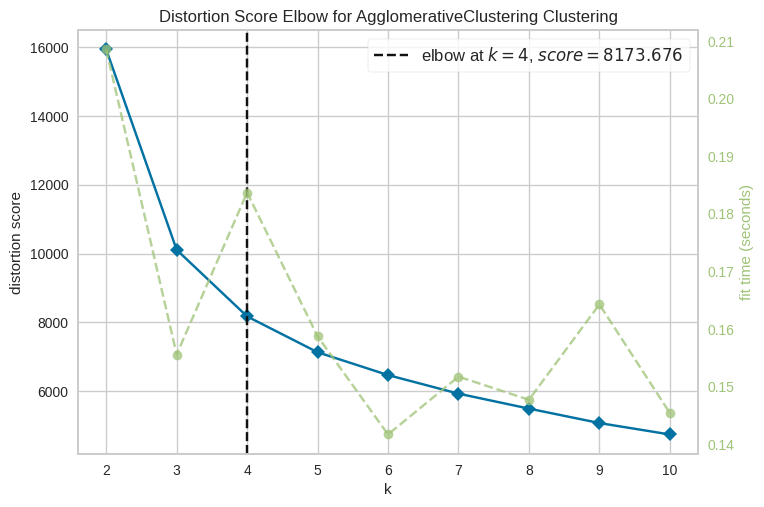

<Axes: title={'center': 'Distortion Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
# implement elbow method for recommendation of effective number of clusters
Elbow_M = KElbowVisualizer(AgglomerativeClustering(), k=10)
Elbow_M.fit(PCA_ds)
Elbow_M.show()

In [ ]:
#Model Initiating (AC)
AC = AgglomerativeClustering(n_clusters=4)
# fit model and predict clusters
yhat_AC = AC.fit_predict(PCA_ds)
PCA_ds["Clusters"] = yhat_AC
#Adding the Clusters feature to the orignal dataframe.
data["Clusters"]= yhat_AC

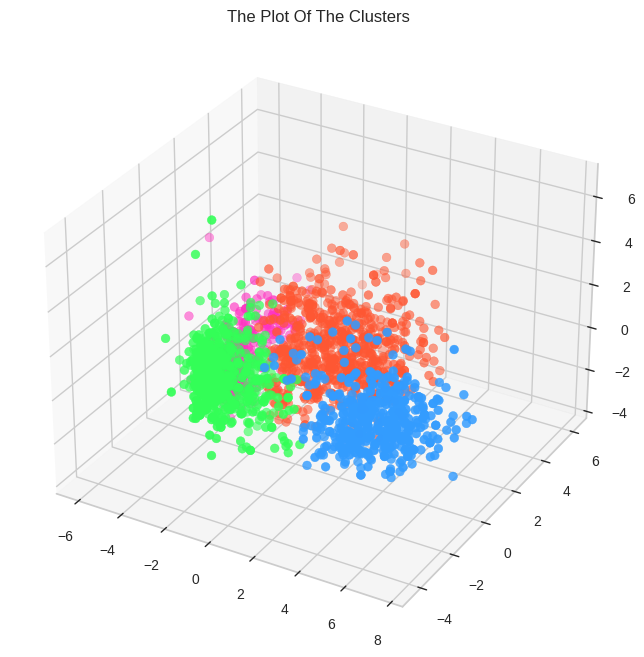

In [ ]:
#Plotting the clusters
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
cmap = colors.ListedColormap(['#FF5733', '#33FF57', '#339CFF', '#FF33C2'])
ax.scatter(x, y, z, s=40, c=PCA_ds["Clusters"], marker='o', cmap = cmap )
ax.set_title("The Plot Of The Clusters")
plt.show()

#Model Evaluation

In [ ]:

from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
# Calculate Silhouette Score
silhouette_avg = silhouette_score(PCA_ds, AC.labels_)

# Calculate Davies-Bouldin Index
db_index = davies_bouldin_score(PCA_ds, AC.labels_)

print("silhouette score: ", silhouette_avg)
print("Davies-Bouldin Index: ", db_index)

silhouette score:  0.4373557193798441
Davies-Bouldin Index:  0.8272098205711403


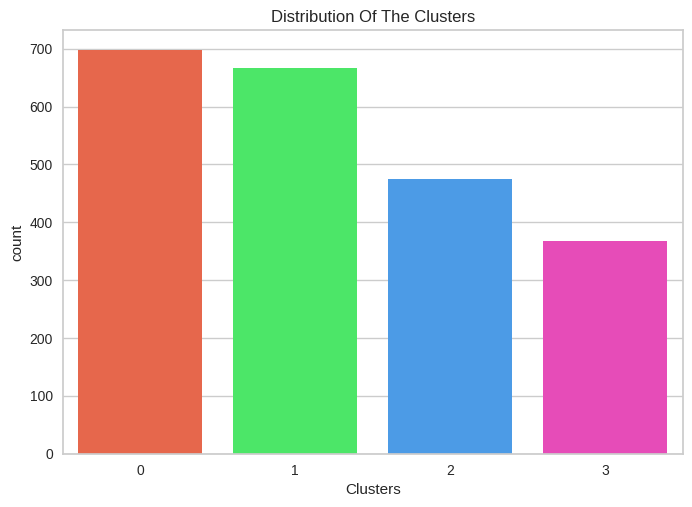

In [ ]:
#Plotting countplot of clusters
#pal = ["#FF4133", "#FFDC00", "#0074D9", "#2ECC40"]
#pal=['#D81B60', '#FFC107', '#2196F3', '#4CAF50']
#pal= ['#E57373', '#81C784', '#64B5F6', '#FFD54F']
pal=['#FF5733', '#33FF57', '#339CFF', '#FF33C2']
pl = sns.countplot(x=data["Clusters"], palette= pal)
pl.set_title("Distribution Of The Clusters")
plt.show()

#Clustering Analysis

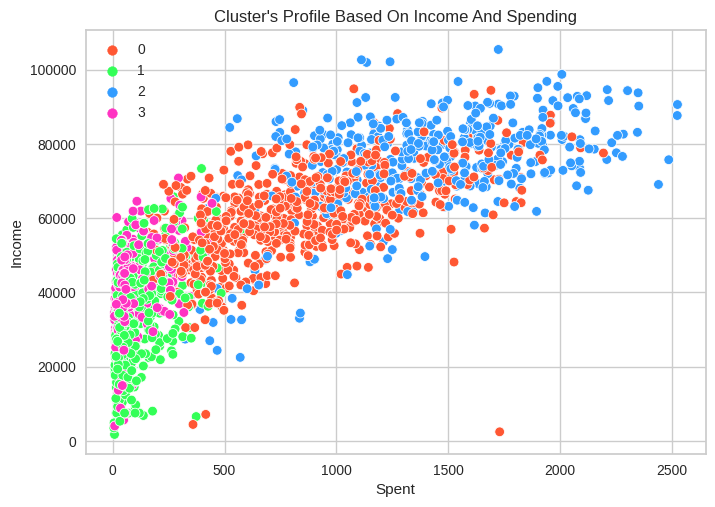

In [ ]:
pl = sns.scatterplot(data = data,x=data["Spent"], y=data["Income"],hue=data["Clusters"], palette= pal)
pl.set_title("Cluster's Profile Based On Income And Spending")
plt.legend()
plt.show()

**Group 0**: High spending and high income

**Group 1**: Low spending and low income

**Group 2**: High spending and high income

**Group 3**: Low spending and average income

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3544: UserWarning: 21.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3544: UserWarning: 72.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3544: UserWarning: 56.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3544: UserWarning: 30.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3544: UserWarning: 75.8% of the points cannot be plac

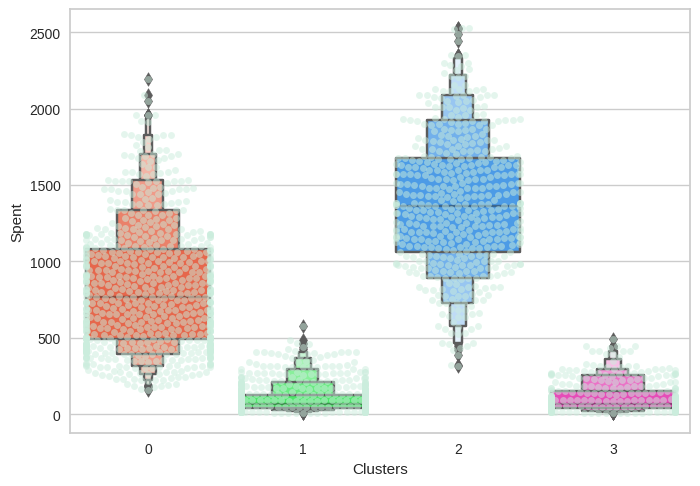

In [ ]:
plt.figure()
pl=sns.swarmplot(x=data["Clusters"], y=data["Spent"], color= "#CBEDDD", alpha=0.5 )
pl=sns.boxenplot(x=data["Clusters"], y=data["Spent"], palette=pal)
plt.show()

**From the above plot, it can be clearly seen that cluster 2 is our biggest set of customers closely followed by cluster 0. We can explore what each cluster is spending on for the targeted marketing strategies.**

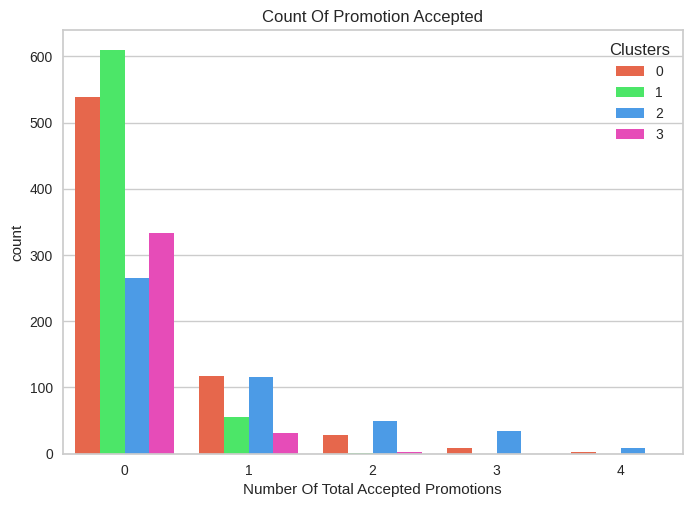

In [ ]:
#Creating a feature to get a sum of accepted promotions
data["Total_Promos"] = data["AcceptedCmp1"]+ data["AcceptedCmp2"]+ data["AcceptedCmp3"]+ data["AcceptedCmp4"]+ data["AcceptedCmp5"]
#Plotting count of total campaign accepted.
plt.figure()
pl = sns.countplot(x=data["Total_Promos"],hue=data["Clusters"], palette= pal)
pl.set_title("Count Of Promotion Accepted")
pl.set_xlabel("Number Of Total Accepted Promotions")
plt.show()

**There has not been an overwhelming response to the campaigns so far. Very few participants overall. Moreover, no one part take in all 5 of them. Perhaps better-targeted and well-planned campaigns are required to boost sales.**

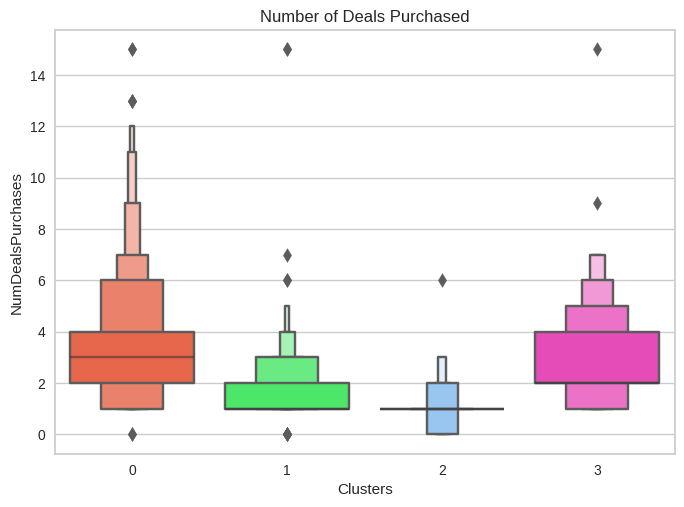

In [ ]:
#Plotting the number of deals purchased
plt.figure()
pl=sns.boxenplot(y=data["NumDealsPurchases"],x=data["Clusters"], palette= pal)
pl.set_title("Number of Deals Purchased")
plt.show()

**Unlike campaigns, the deals offered did well. It has best outcome with cluster 0 and cluster 3. However, our star customers cluster 2 are not much into the deals. Nothing seems to attract cluster 1 overwhelmingly**

**PROFILING**

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1877: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(x=self.x, ax=self.ax_marg_x, **kwargs)


<Figure size 800x550 with 0 Axes>

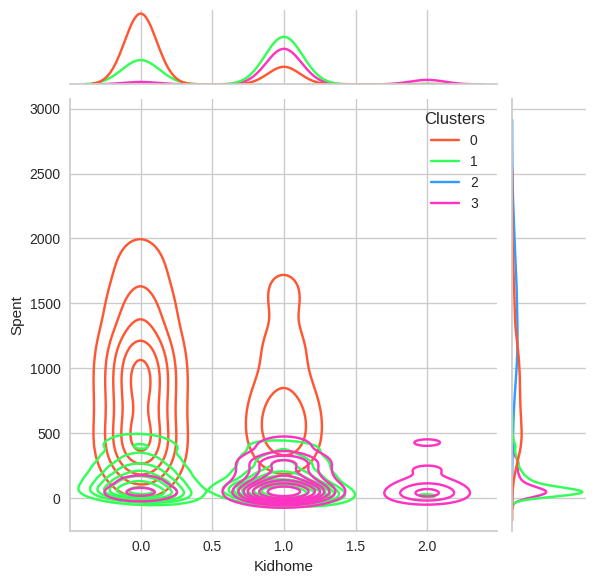

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1877: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(x=self.x, ax=self.ax_marg_x, **kwargs)


<Figure size 800x550 with 0 Axes>

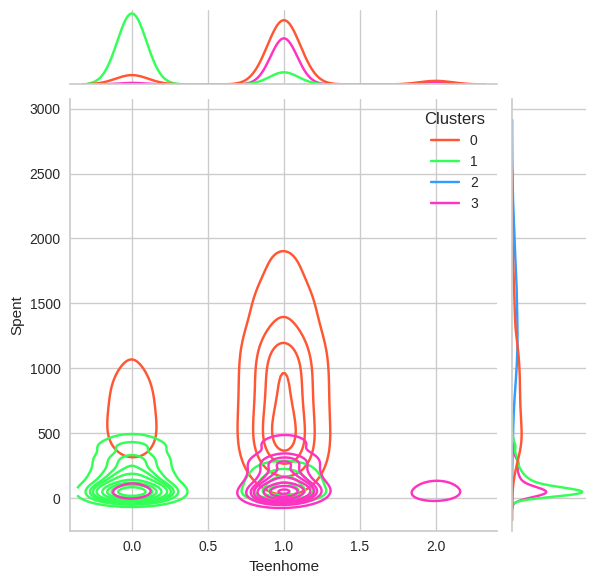

<Figure size 800x550 with 0 Axes>

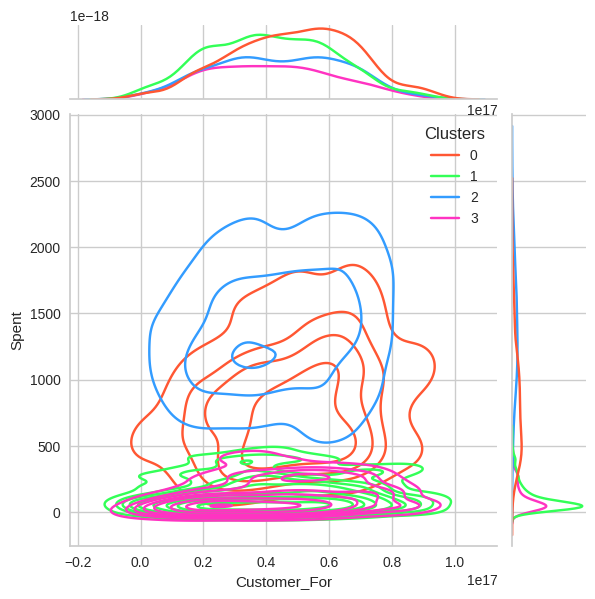

<Figure size 800x550 with 0 Axes>

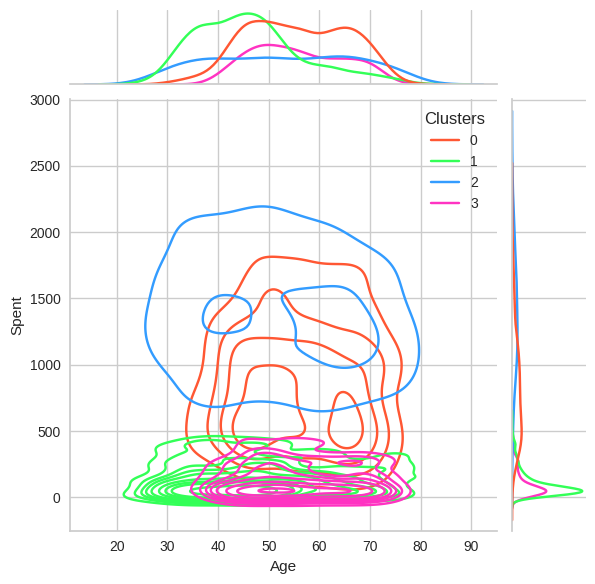

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1877: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(x=self.x, ax=self.ax_marg_x, **kwargs)


<Figure size 800x550 with 0 Axes>

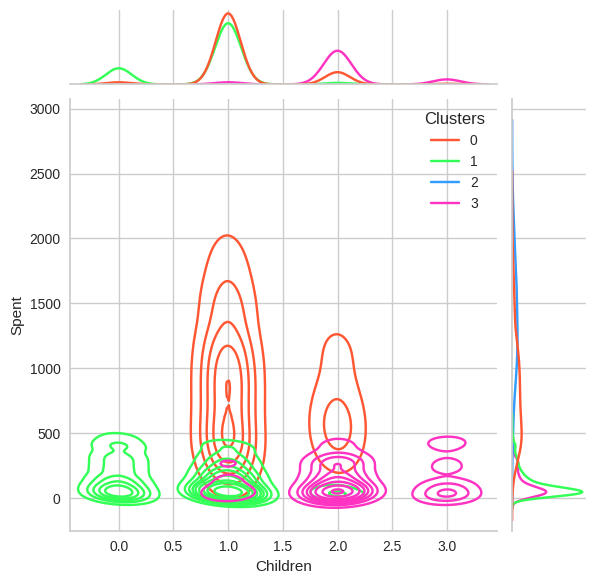

<Figure size 800x550 with 0 Axes>

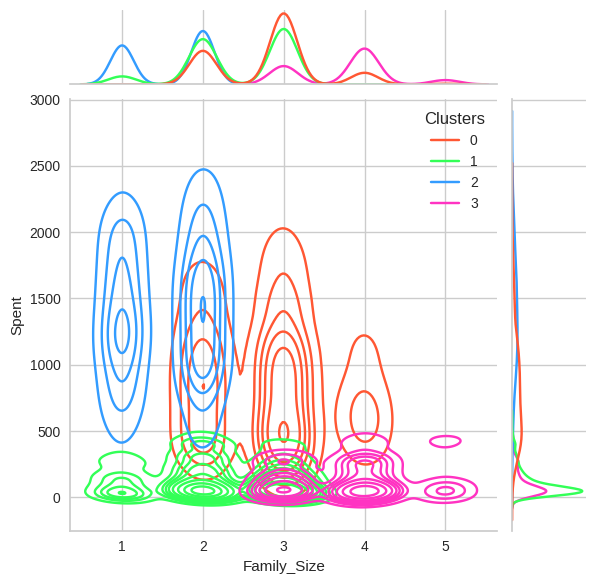

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1877: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(x=self.x, ax=self.ax_marg_x, **kwargs)


<Figure size 800x550 with 0 Axes>

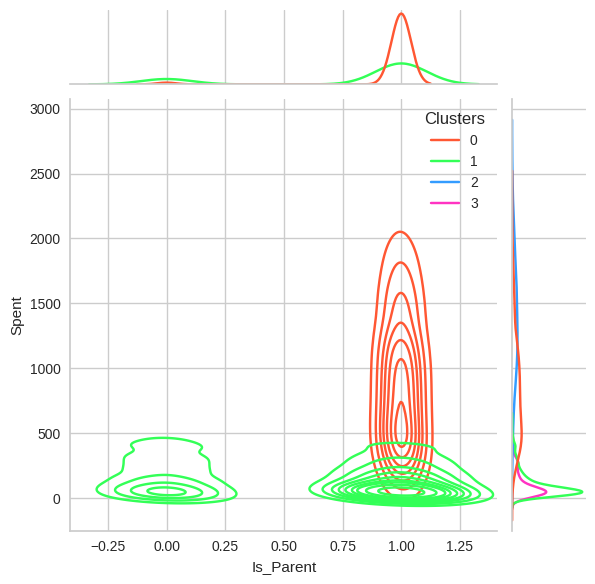

<Figure size 800x550 with 0 Axes>

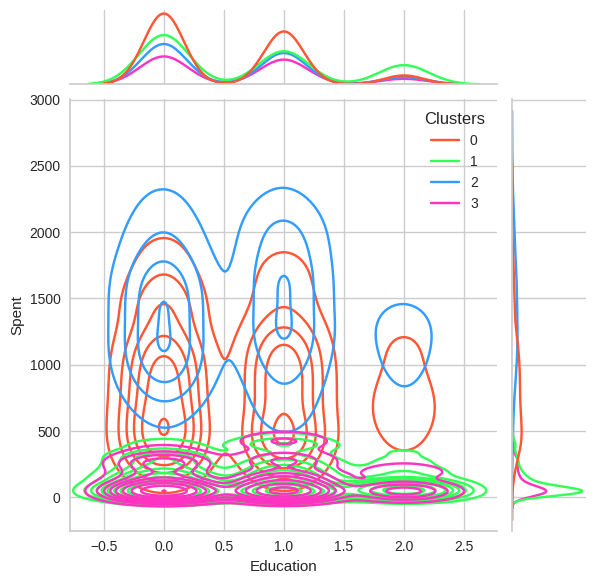

<Figure size 800x550 with 0 Axes>

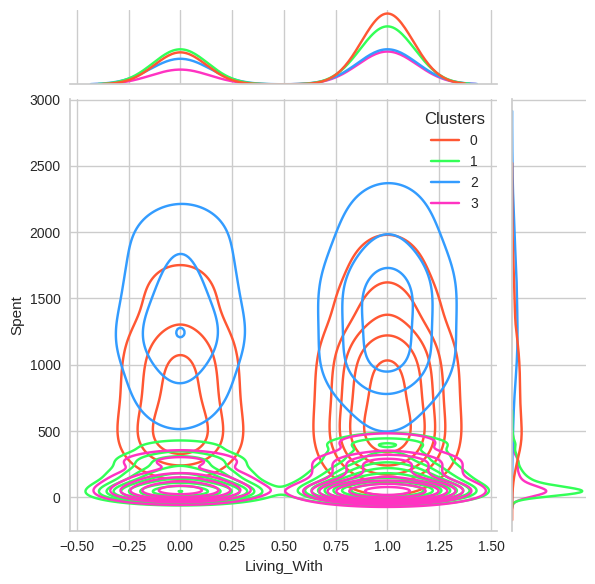

In [ ]:
Personal = [ "Kidhome","Teenhome","Customer_For", "Age", "Children", "Family_Size", "Is_Parent","Education","Living_With"]

for i in Personal:
    plt.figure()
    sns.jointplot(x=ds[i], y=data["Spent"], hue =data["Clusters"], kind="kde", palette=pal)
    plt.show()

**Cluster 0**
- Are definitely a parent
- At the max have 4 members in the family and at least 2
- Most have teenager at home
- Relatively older

**Cluster 1**
- The majority of these people are parents
- At the max are 3 members in the family
- They majorly have one kid and not teenagers
- Relatively younger

**Cluster 2**
- Are definitely not a parent
- At the max of 2 people in the family
- All ages

**Cluster 3**
- Definitely a parent
- At the max of 5 members and at least 3 in the family
- Majority have teenager
- Relatively older


#Apendix

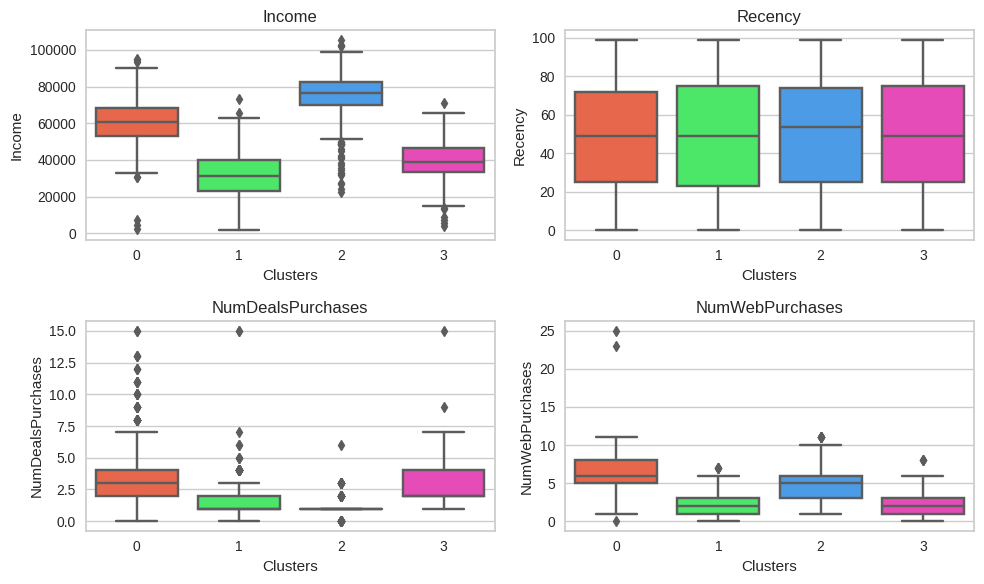

In [ ]:
plt.figure(figsize=(10, 6))
for i, feature in enumerate(['Income', 'Recency', 'NumDealsPurchases', 'NumWebPurchases']):
    plt.subplot(2, 2, i+1)
    sns.boxplot(x='Clusters', y=feature, data=data,palette= pal )
    plt.title(feature)
plt.tight_layout()
plt.show()

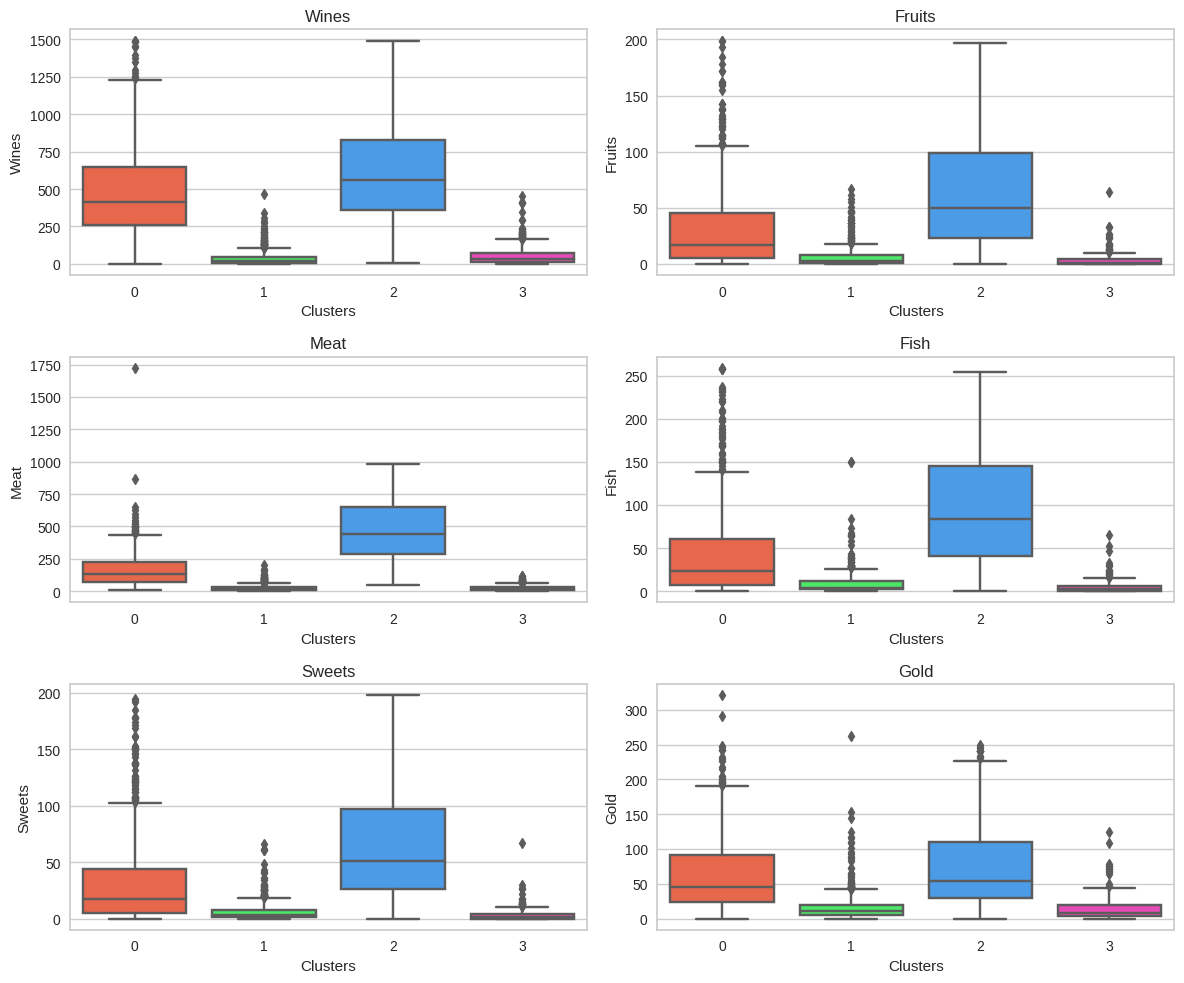

In [ ]:
plt.figure(figsize=(12, 10))
for i, feature in enumerate(['Wines', 'Fruits', 'Meat', 'Fish', 'Sweets', 'Gold']):
    plt.subplot(3, 2, i+1)
    sns.boxplot(x='Clusters', y=feature, data=data, palette= pal)
    plt.title(feature)
plt.tight_layout()
plt.show()

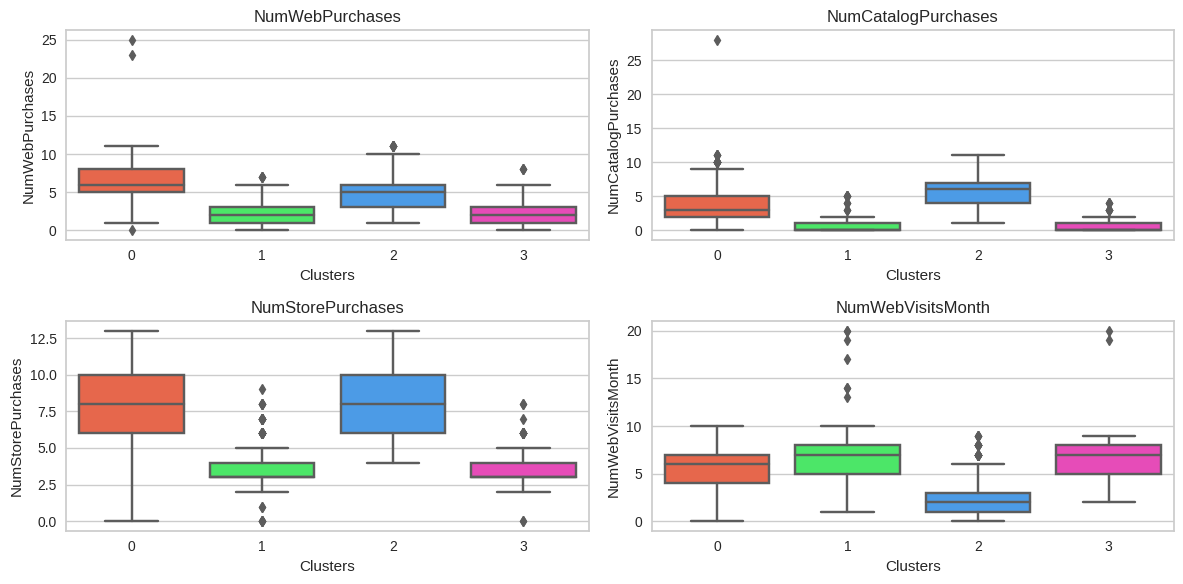

In [ ]:
plt.figure(figsize=(12, 6))
for i, feature in enumerate([ 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']):
    plt.subplot(2, 2, i+1)
    sns.boxplot(x='Clusters', y=feature, data=data,palette=pal)
    plt.title(feature)
plt.tight_layout()
plt.show()

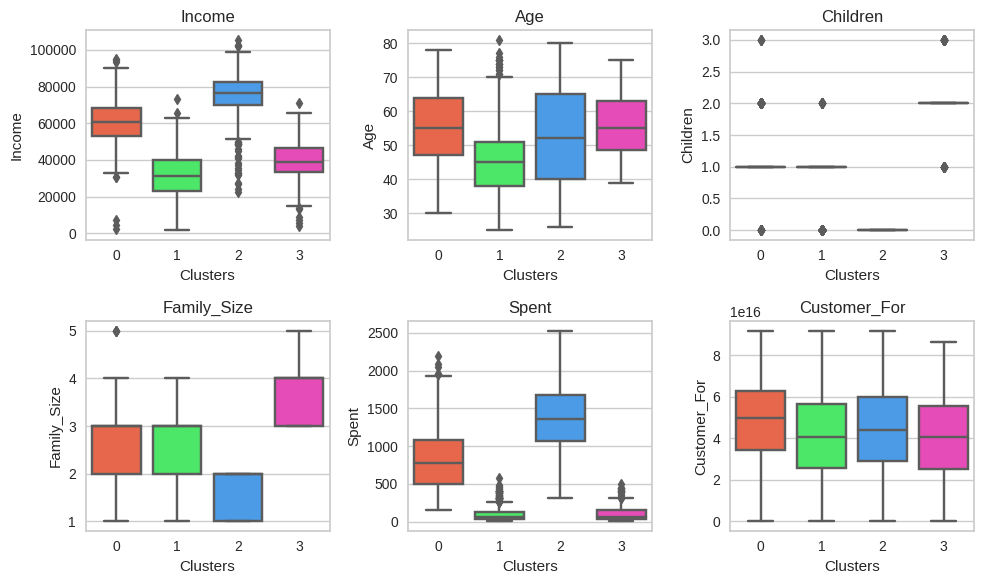

In [ ]:
plt.figure(figsize=(10, 6))
for i, feature in enumerate([ 'Income', 'Age', 'Children', 'Family_Size','Spent','Customer_For']):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x='Clusters', y=feature, data=data, palette=pal)
    plt.title(feature)
plt.tight_layout()
plt.show()

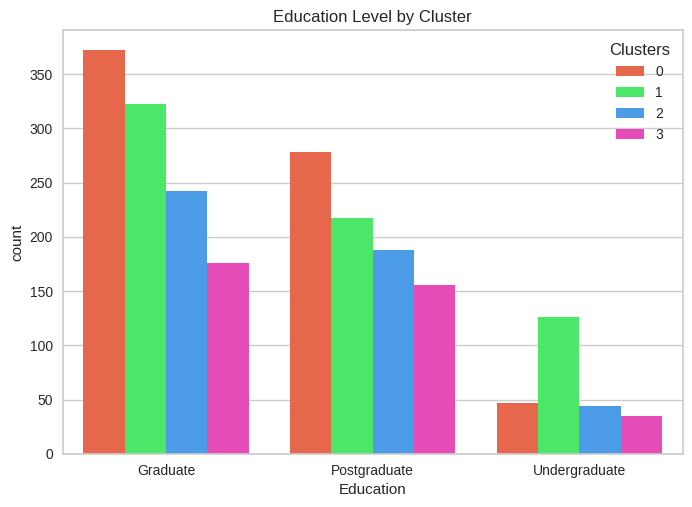

In [ ]:
sns.countplot(x='Education', hue='Clusters', data=data, palette=pal)
plt.title('Education Level by Cluster')
plt.show()

In [ ]:
# Define the feature for which you want to use describe() for each cluster
feature_name = 'Income'

# Iterate through unique cluster labels and apply describe() to the specified feature
for cluster_label in data['Clusters'].unique():
    cluster_data = data[data['Clusters'] == cluster_label]
    feature_description = cluster_data[feature_name].describe()

    print(f"Cluster {cluster_label} - {feature_name} Description:")

Cluster 2 - Income Description:
Cluster 1 - Income Description:
Cluster 0 - Income Description:
Cluster 3 - Income Description:


In [ ]:
# Define the features for which you want to compute statistics
feature_names = [ 'Income']  # Add more features if needed

# Group the data by 'Clusters' and compute statistics for specified features
cluster_stats = data.groupby('Clusters')[feature_names].describe(percentiles=[.25, .50, .75])

# Print the statistics for each cluster
print(cluster_stats)

         Income                                                          \
          count          mean           std      min       25%      50%   
Clusters                                                                  
0         697.0  60650.464849  11790.583197   2447.0  53230.00  60934.0   
1         666.0  31990.567568  12115.724171   1730.0  23277.75  31163.0   
2         474.0  75129.120253  12404.614709  22507.0  69728.00  76641.5   
3         367.0  39571.362398  11194.373046   4023.0  33420.00  38741.0   

                              
               75%       max  
Clusters                      
0         68118.00   94871.0  
1         39770.00   73395.0  
2         82487.75  105471.0  
3         46443.00   70844.0  


In [ ]:
# Define the features for which you want to compute statistics
feature_names = [ 'Age']  # Add more features if needed

# Group the data by 'Clusters' and compute statistics for specified features
cluster_stats = data.groupby('Clusters')[feature_names].describe(percentiles=[.25, .50, .75])

# Print the statistics for each cluster
print(cluster_stats)

            Age                                                    
          count       mean        std   min   25%   50%   75%   max
Clusters                                                           
0         697.0  55.578192   9.834112  30.0  47.0  55.0  64.0  78.0
1         666.0  46.028529  10.467886  25.0  38.0  45.0  51.0  81.0
2         474.0  52.670886  14.121390  26.0  40.0  52.0  65.0  80.0
3         367.0  55.683924   8.913877  39.0  48.5  55.0  63.0  75.0


In [ ]:
# Define the features for which you want to compute statistics
feature_names = [ 'Recency']  # Add more features if needed

# Group the data by 'Clusters' and compute statistics for specified features
cluster_stats = data.groupby('Clusters')[feature_names].describe(percentiles=[.25, .50, .75])

# Print the statistics for each cluster
print(cluster_stats)

         Recency                                                     
           count       mean        std  min    25%   50%    75%   max
Clusters                                                             
0          697.0  48.717360  28.908181  0.0  25.00  49.0  72.00  99.0
1          666.0  48.795796  28.902591  0.0  23.25  49.0  75.00  99.0
2          474.0  49.974684  29.070945  0.0  25.00  53.5  73.75  99.0
3          367.0  48.811989  28.908090  0.0  25.00  49.0  75.00  99.0


In [ ]:
# Define the features for which you want to compute statistics
feature_names = [ 'NumDealsPurchases']  # Add more features if needed

# Group the data by 'Clusters' and compute statistics for specified features
cluster_stats = data.groupby('Clusters')[feature_names].describe(percentiles=[.25, .50, .75])

# Print the statistics for each cluster
print(cluster_stats)

         NumDealsPurchases                                              
                     count      mean       std  min  25%  50%  75%   max
Clusters                                                                
0                    697.0  3.444763  2.275596  0.0  2.0  3.0  4.0  15.0
1                    666.0  1.723724  1.198473  0.0  1.0  1.0  2.0  15.0
2                    474.0  1.048523  0.519969  0.0  1.0  1.0  1.0   6.0
3                    367.0  2.904632  1.763056  1.0  2.0  2.0  4.0  15.0


In [ ]:
# Define the features for which you want to compute statistics
feature_names = [ 'NumWebPurchases']  # Add more features if needed

# Group the data by 'Clusters' and compute statistics for specified features
cluster_stats = data.groupby('Clusters')[feature_names].describe(percentiles=[.25, .50, .75])

# Print the statistics for each cluster
print(cluster_stats)

         NumWebPurchases                                              
                   count      mean       std  min  25%  50%  75%   max
Clusters                                                              
0                  697.0  6.375897  2.534678  0.0  5.0  6.0  8.0  25.0
1                  666.0  2.126126  1.300899  0.0  1.0  2.0  3.0   7.0
2                  474.0  4.900844  1.984261  1.0  3.0  5.0  6.0  11.0
3                  367.0  2.267030  1.469016  0.0  1.0  2.0  3.0   8.0


In [ ]:
# Define the features for which you want to compute statistics
feature_names = [ 'NumCatalogPurchases']  # Add more features if needed

# Group the data by 'Clusters' and compute statistics for specified features
cluster_stats = data.groupby('Clusters')[feature_names].describe(percentiles=[.25, .50, .75])

# Print the statistics for each cluster
print(cluster_stats)

         NumCatalogPurchases                                              
                       count      mean       std  min  25%  50%  75%   max
Clusters                                                                  
0                      697.0  3.549498  2.432580  0.0  2.0  3.0  5.0  28.0
1                      666.0  0.555556  0.781789  0.0  0.0  0.0  1.0   5.0
2                      474.0  5.824895  2.404394  1.0  4.0  6.0  7.0  11.0
3                      367.0  0.621253  0.779439  0.0  0.0  0.0  1.0   4.0


In [ ]:
# Define the features for which you want to compute statistics
feature_names = [ 'NumStorePurchases']  # Add more features if needed

# Group the data by 'Clusters' and compute statistics for specified features
cluster_stats = data.groupby('Clusters')[feature_names].describe(percentiles=[.25, .50, .75])

# Print the statistics for each cluster
print(cluster_stats)

         NumStorePurchases                                               
                     count      mean       std  min  25%  50%   75%   max
Clusters                                                                 
0                    697.0  7.931133  2.759699  0.0  6.0  8.0  10.0  13.0
1                    666.0  3.223724  1.161840  0.0  3.0  3.0   4.0   9.0
2                    474.0  8.308017  2.803286  4.0  6.0  8.0  10.0  13.0
3                    367.0  3.346049  1.092763  0.0  3.0  3.0   4.0   8.0


In [ ]:
# Define the features for which you want to compute statistics
feature_names = [ 'NumWebVisitsMonth']  # Add more features if needed

# Group the data by 'Clusters' and compute statistics for specified features
cluster_stats = data.groupby('Clusters')[feature_names].describe(percentiles=[.25, .50, .75])

# Print the statistics for each cluster
print(cluster_stats)

         NumWebVisitsMonth                                              
                     count      mean       std  min  25%  50%  75%   max
Clusters                                                                
0                    697.0  5.436155  1.923616  0.0  4.0  6.0  7.0  10.0
1                    666.0  6.525526  2.040222  1.0  5.0  7.0  8.0  20.0
2                    474.0  2.675105  1.828808  0.0  1.0  2.0  3.0   9.0
3                    367.0  6.441417  1.765246  2.0  5.0  7.0  8.0  20.0


In [ ]:
# Define the features for which you want to compute statistics
feature_names = [ 'Spent']  # Add more features if needed

# Group the data by 'Clusters' and compute statistics for specified features
cluster_stats = data.groupby('Clusters')[feature_names].describe(percentiles=[.25, .50, .75])

# Print the statistics for each cluster
print(cluster_stats)

          Spent                                                           \
          count         mean         std    min     25%     50%      75%   
Clusters                                                                   
0         697.0   827.222382  404.265455  156.0   495.0   770.0  1079.00   
1         666.0   100.117117   94.920456    5.0    38.0    65.0   128.75   
2         474.0  1381.801688  444.207405  316.0  1062.0  1364.5  1676.75   
3         367.0   107.735695  101.182670    8.0    40.0    64.0   149.50   

                  
             max  
Clusters          
0         2194.0  
1          577.0  
2         2525.0  
3          493.0  


In [ ]:
# Define the features for which you want to compute statistics
feature_names = [ 'Children']  # Add more features if needed

# Group the data by 'Clusters' and compute statistics for specified features
cluster_stats = data.groupby('Clusters')[feature_names].describe(percentiles=[.25, .50, .75])

# Print the statistics for each cluster
print(cluster_stats)

         Children                                             
            count      mean       std  min  25%  50%  75%  max
Clusters                                                      
0           697.0  1.131994  0.421847  0.0  1.0  1.0  1.0  3.0
1           666.0  0.815315  0.435776  0.0  1.0  1.0  1.0  2.0
2           474.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0
3           367.0  2.070845  0.412105  1.0  2.0  2.0  2.0  3.0


In [ ]:
# Define the features for which you want to compute statistics
feature_names = [ 'Family_Size']  # Add more features if needed

# Group the data by 'Clusters' and compute statistics for specified features
cluster_stats = data.groupby('Clusters')[feature_names].describe(percentiles=[.25, .50, .75])

# Print the statistics for each cluster
print(cluster_stats)

         Family_Size                                             
               count      mean       std  min  25%  50%  75%  max
Clusters                                                         
0              697.0  2.820660  0.618887  1.0  2.0  3.0  3.0  5.0
1              666.0  2.438438  0.630045  1.0  2.0  3.0  3.0  4.0
2              474.0  1.578059  0.494391  1.0  1.0  2.0  2.0  2.0
3              367.0  3.760218  0.574740  3.0  3.0  4.0  4.0  5.0


In [ ]:
# Define the features for which you want to compute statistics
feature_names = [ 'Customer_For']  # Add more features if needed

# Group the data by 'Clusters' and compute statistics for specified features
cluster_stats = data.groupby('Clusters')[feature_names].describe(percentiles=[.25, .50, .75])

# Print the statistics for each cluster
print(cluster_stats)

         Customer_For                                                          \
                count          mean           std           min           25%   
Clusters                                                                        
0               697.0  4.860973e+16  1.955981e+16  8.640000e+13  3.438720e+16   
1               666.0  4.146915e+16  1.972951e+16  0.000000e+00  2.574720e+16   
2               474.0  4.415550e+16  2.030358e+16  8.640000e+13  2.911680e+16   
3               367.0  4.116713e+16  2.002860e+16  8.640000e+13  2.518560e+16   

                                                    
                   50%           75%           max  
Clusters                                            
0         4.959360e+16  6.289920e+16  9.184320e+16  
1         4.086720e+16  5.657040e+16  9.184320e+16  
2         4.415040e+16  5.985360e+16  9.184320e+16  
3         4.069440e+16  5.551200e+16  8.640000e+16  


In [ ]:
# Define the features for which you want to compute statistics
feature_names = [ 'Kidhome']  # Add more features if needed

# Group the data by 'Clusters' and compute statistics for specified features
cluster_stats = data.groupby('Clusters')[feature_names].describe(percentiles=[.25, .50, .75])

# Print the statistics for each cluster
print(cluster_stats)

         Kidhome                                             
           count      mean       std  min  25%  50%  75%  max
Clusters                                                     
0          697.0  0.206600  0.415659  0.0  0.0  0.0  0.0  2.0
1          666.0  0.669670  0.483296  0.0  0.0  1.0  1.0  2.0
2          474.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0
3          367.0  1.049046  0.401898  0.0  1.0  1.0  1.0  2.0


In [ ]:
# Define the features for which you want to compute statistics
feature_names = [ 'Teenhome']  # Add more features if needed

# Group the data by 'Clusters' and compute statistics for specified features
cluster_stats = data.groupby('Clusters')[feature_names].describe(percentiles=[.25, .50, .75])

# Print the statistics for each cluster
print(cluster_stats)

         Teenhome                                             
            count      mean       std  min  25%  50%  75%  max
Clusters                                                      
0           697.0  0.925395  0.401364  0.0  1.0  1.0  1.0  2.0
1           666.0  0.145646  0.353016  0.0  0.0  0.0  0.0  1.0
2           474.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0
3           367.0  1.021798  0.285466  0.0  1.0  1.0  1.0  2.0


In [ ]:
# Define the features for which you want to compute statistics
feature_names = [ 'Wines']  # Add more features if needed

# Group the data by 'Clusters' and compute statistics for specified features
cluster_stats = data.groupby('Clusters')[feature_names].describe(percentiles=[.25, .50, .75])

# Print the statistics for each cluster
print(cluster_stats)

          Wines                                                           
          count        mean         std  min    25%    50%     75%     max
Clusters                                                                  
0         697.0  487.456241  299.020068  1.0  261.0  415.0  650.00  1492.0
1         666.0   37.825826   53.592192  0.0    5.0   16.0   45.00   464.0
2         474.0  607.759494  320.859656  7.0  358.0  562.5  829.75  1493.0
3         367.0   60.108992   72.331425  1.0   15.0   30.0   75.00   456.0


In [ ]:
# Define the features for which you want to compute statistics
feature_names = [ 'Fruits']  # Add more features if needed

# Group the data by 'Clusters' and compute statistics for specified features
cluster_stats = data.groupby('Clusters')[feature_names].describe(percentiles=[.25, .50, .75])

# Print the statistics for each cluster
print(cluster_stats)

         Fruits                                                     
          count       mean        std  min   25%   50%    75%    max
Clusters                                                            
0         697.0  31.846485  38.095852  0.0   5.0  17.0  45.00  199.0
1         666.0   6.357357   9.274020  0.0   1.0   3.0   8.00   67.0
2         474.0  64.670886  50.921543  0.0  23.0  49.5  98.75  197.0
3         367.0   3.084469   5.762224  0.0   0.0   1.0   4.00   64.0


In [ ]:
# Define the features for which you want to compute statistics
feature_names = [ 'Meat']  # Add more features if needed

# Group the data by 'Clusters' and compute statistics for specified features
cluster_stats = data.groupby('Clusters')[feature_names].describe(percentiles=[.25, .50, .75])

# Print the statistics for each cluster
print(cluster_stats)

           Meat                                                             
          count        mean         std   min     25%    50%     75%     max
Clusters                                                                    
0         697.0  167.051650  134.156208   6.0   75.00  134.0  222.00  1725.0
1         666.0   24.358859   27.143817   0.0    7.25   15.0   28.75   204.0
2         474.0  471.331224  235.555988  48.0  291.25  445.0  652.50   984.0
3         367.0   23.000000   22.908108   1.0    8.00   15.0   29.50   119.0


In [ ]:
# Define the features for which you want to compute statistics
feature_names = [ 'Fish']  # Add more features if needed

# Group the data by 'Clusters' and compute statistics for specified features
cluster_stats = data.groupby('Clusters')[feature_names].describe(percentiles=[.25, .50, .75])

# Print the statistics for each cluster
print(cluster_stats)

           Fish                                                      
          count       mean        std  min    25%   50%    75%    max
Clusters                                                             
0         697.0  43.311334  52.348734  0.0   7.00  23.0   60.0  259.0
1         666.0   8.782282  13.313876  0.0   2.00   4.0   12.0  150.0
2         474.0  96.101266  64.698016  0.0  41.25  84.0  145.0  254.0
3         367.0   4.531335   7.188217  0.0   0.00   2.0    6.0   65.0


In [ ]:
# Define the features for which you want to compute statistics
feature_names = [ 'Sweets']  # Add more features if needed

# Group the data by 'Clusters' and compute statistics for specified features
cluster_stats = data.groupby('Clusters')[feature_names].describe(percentiles=[.25, .50, .75])

# Print the statistics for each cluster
print(cluster_stats)

         Sweets                                                    
          count       mean        std  min   25%   50%   75%    max
Clusters                                                           
0         697.0  32.935438  40.245334  0.0   5.0  17.0  44.0  195.0
1         666.0   6.273273   8.482114  0.0   1.0   3.0   8.0   66.0
2         474.0  66.023207  51.296319  0.0  26.0  51.0  97.0  198.0
3         367.0   3.070845   5.474770  0.0   0.0   1.0   4.0   67.0


In [ ]:
# Define the features for which you want to compute statistics
feature_names = [ 'Gold']  # Add more features if needed

# Group the data by 'Clusters' and compute statistics for specified features
cluster_stats = data.groupby('Clusters')[feature_names].describe(percentiles=[.25, .50, .75])

# Print the statistics for each cluster
print(cluster_stats)

           Gold                                                      
          count       mean        std  min   25%   50%     75%    max
Clusters                                                             
0         697.0  64.621234  54.975386  0.0  24.0  46.0   91.00  321.0
1         666.0  16.519520  21.340077  0.0   5.0  11.0   20.00  262.0
2         474.0  75.915612  61.352181  0.0  30.0  54.0  110.25  249.0
3         367.0  13.940054  16.286597  0.0   3.0   8.0   20.00  125.0
